In [1]:
!nvidia-smi

Tue Jun 20 03:07:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
# %cd {HOME}
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-" -O vehicle-counting.mp4 && rm -rf /tmp/cookies.txt

In [3]:
SOURCE_VIDEO_PATH ="/content/test.mp4"

In [ ]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.120 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.1/78.2 GB disk)


In [ ]:
!pip install loguru

In [ ]:
!pip install yolox

In [ ]:
!pip install thop

In [ ]:
!pip install lap

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [4]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [6]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [5]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [7]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## Load pre-trained YOLOv8 model

In [8]:
# settings
#MODEL = "/content/drive/MyDrive/best.pt"

MODEL="yolov8m.pt"

In [9]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 49.7M/49.7M [00:03<00:00, 15.5MB/s]
YOLOv8m summary (fused): 218 layers, 25886080 parameters, 0 gradients, 78.9 GFLOPs


In [10]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.names
CLASS_ID = [0]

In [11]:
model.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou


0: 384x640 14 persons, 1 traffic light, 1 backpack, 3 handbags, 6 chairs, 2 potted plants, 1 dining table, 26.6ms
Speed: 3.2ms preprocess, 26.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


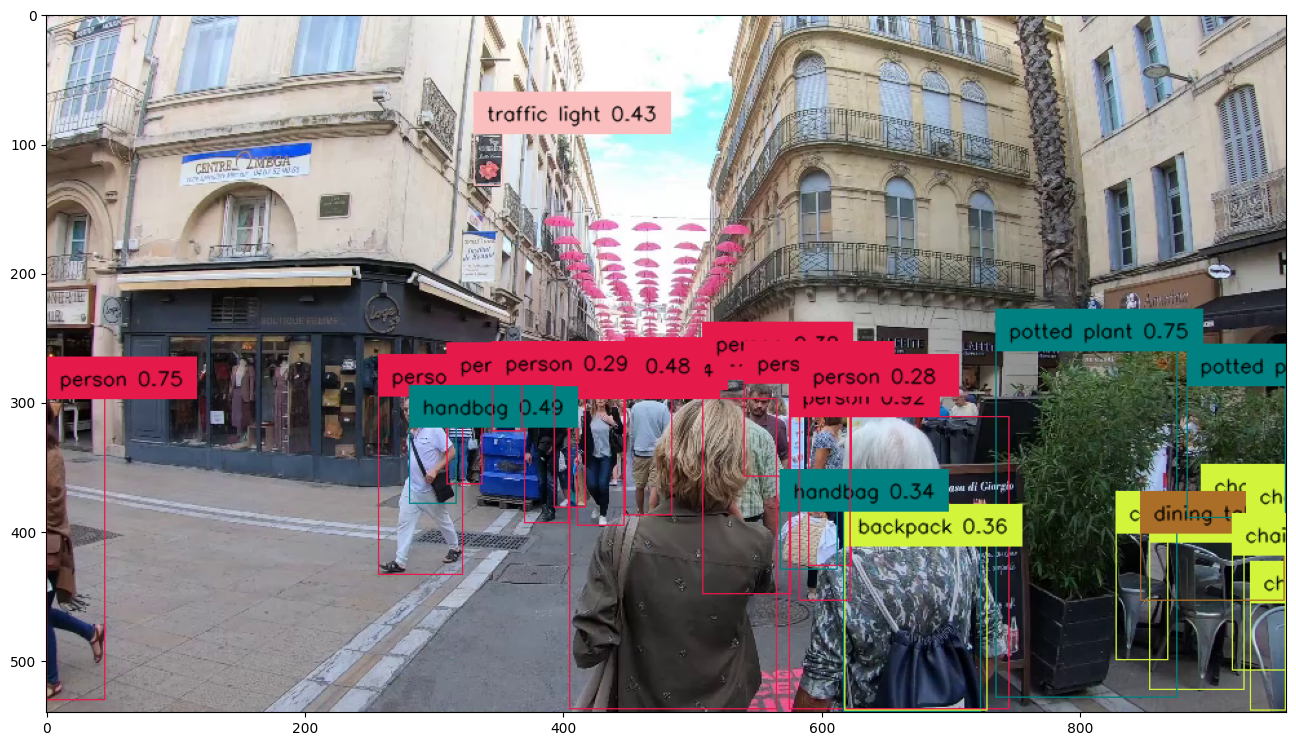

In [63]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=.5)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [12]:
import cv2

# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=.5)

# Get the first frame to obtain video properties
iterator = iter(generator)
frame = next(iterator)
height, width, _ = frame.shape
fps = 30  # Set the desired frames per second for the output video

# Create video writer
output_video_path = "annotated_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Iterate over the video frames
for frame in generator:
    # model prediction on single frame and conversion to supervision Detections
    results = model(frame)
    detections = Detections(
        xyxy=results[0].boxes.xyxy.cpu().numpy(),
        confidence=results[0].boxes.conf.cpu().numpy(),
        class_id=results[0].boxes.cls.cpu().numpy().astype(int)
    )

    # format custom labels
    labels = [
        f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
        for _, confidence, class_id, tracker_id
        in detections
    ]

    # annotate frame
    annotated_frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

    # write annotated frame to video file
    video_writer.write(annotated_frame)

# Release the video writer
video_writer.release()

print("Annotated video saved successfully.")



0: 384x640 14 persons, 1 backpack, 6 handbags, 6 chairs, 1 potted plant, 2 dining tables, 87.8ms
Speed: 3.6ms preprocess, 87.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 13 persons, 1 backpack, 4 handbags, 6 chairs, 2 potted plants, 2 dining tables, 26.0ms
Speed: 2.8ms preprocess, 26.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 13 persons, 1 traffic light, 4 handbags, 5 chairs, 2 potted plants, 26.0ms
Speed: 8.5ms preprocess, 26.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 13 persons, 1 traffic light, 1 backpack, 3 handbags, 4 chairs, 1 potted plant, 26.1ms
Speed: 2.9ms preprocess, 26.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 13 persons, 4 handbags, 2 chairs, 1 potted plant, 26.0ms
Speed: 2.8ms preprocess, 26.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 11 persons, 5 handbags, 3 chairs, 2 potted plants, 2

Annotated video saved successfully.


In [1]:
import cv2

# Create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=.5)

# Open the camera for video capture
video_capture = cv2.VideoCapture(0)  # 0 represents the default camera index

# Check if the camera was successfully opened
if not video_capture.isOpened():
    print("Failed to open the camera.")
    exit()

# Get the first frame to obtain video properties
ret, frame = video_capture.read()
height, width, _ = frame.shape
fps = 30  # Set the desired frames per second for the output video

# Create video writer
output_video_path = "annotated_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Iterate over the frames from the camera
while True:
    # Read the next frame from the camera
    ret, frame = video_capture.read()

    # Check if the frame was successfully captured
    if not ret:
        print("Failed to capture frame.")
        break

    # Perform model prediction on single frame and conversion to supervision Detections
    results = model(frame)
    detections = Detections(
        xyxy=results[0].boxes.xyxy.cpu().numpy(),
        confidence=results[0].boxes.conf.cpu().numpy(),
        class_id=results[0].boxes.cls.cpu().numpy().astype(int)
    )

    # Format custom labels
    labels = [
        f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
        for _, confidence, class_id, tracker_id
        in detections
    ]

    # Annotate frame
    annotated_frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

    # Write annotated frame to video file
    video_writer.write(annotated_frame)

    # Display frame
    cv2.imshow("Annotated Frame", annotated_frame)

    # Press 'q' to exit the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and video writer
video_capture.release()
video_writer.release()

# Destroy any remaining OpenCV windows
cv2.destroyAllWindows()


NameError: ignored